In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run helper.py

In [3]:
hiv_train = pd.read_csv('./data/training_data.csv', index_col='PatientID'); hiv_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 5 columns):
Resp      1000 non-null int64
PR Seq    920 non-null object
RT Seq    1000 non-null object
VL-t0     1000 non-null float64
CD4-t0    1000 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 39.1+ KB


In [4]:
# lets print out the class distribution
hiv_train.Resp.value_counts()

0    794
1    206
dtype: int64

### Out of 1000 examples only 206 patients successfully responded to antiretroviral therapy.
<p>Class distribution is skewed, there are around 794 patients who did not respond well to the therapy.</p>
<p>Loss metric used is <b><em>misclassification rate.</em></b></p>

In [5]:
baselineModel = BaselineModel(0, hiv_train.shape[0])

In [6]:
y_predict = baselineModel.predict()

In [7]:
print ('misclassification rate for baseline model is {0:.3f} %'.format(misclassification_percentage(hiv_train.Resp.values, y_predict)))

misclassification rate for baseline model is 20.600 %


### Any model with misclassification rate lower than this is acceptable.

## Data - Exploration

In [8]:
# lets produce summary statistics for numeric-columns
hiv_train.describe()

,Resp,VL-t0,CD4-t0
count,1000.000000,1000.00000,1000.000000
mean,0.206000,4.29721,279.638000
std,0.404633,0.70478,198.186712
min,0.000000,2.70000,0.000000
25%,0.000000,3.70000,132.750000
50%,0.000000,4.30000,249.000000
75%,0.000000,4.80000,383.250000
max,1.000000,6.00000,1589.000000


#### There are only two features which are numeric VL-t0 and CD4-t0, both of which are on a different scale, VL-t0 is in log10 scale and CD4-t0 is on a normal scale

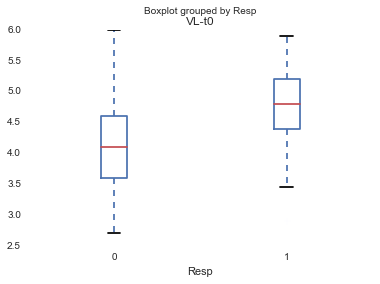

In [9]:
# lets plot the box-plots
hiv_train.boxplot(column='VL-t0', by='Resp');

### Patients that have improved have median value of viral load greater than those that didn't improve. This might indicate that only those patients undergo this therapy who have high viral load value.

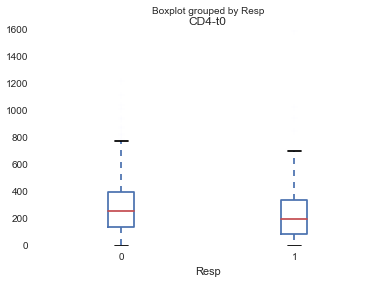

In [10]:
hiv_train.boxplot(column='CD4-t0', by='Resp');

### Generally people in both the categories have identical distribution, but there is patient with very high CD4+ cell count of 1589.0

In [11]:
hiv_train[hiv_train['CD4-t0'] == 1589.0]

,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
PatientID,,,,,
752,1,CCTCAGATCACTCTTTGGCAAMGACCCCTYGTCACAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.45,1589


<b><em>Indeed that person responded well to the therapy.</em></b>

## Exploratory Data Analysis

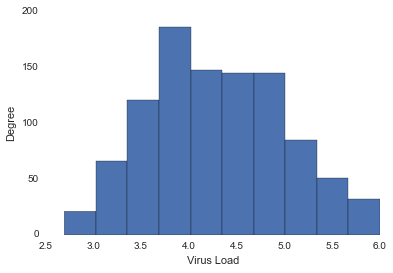

In [12]:
# lets plot the distributions of both the variables
hiv_train['VL-t0'].plot(kind='hist')
plt.xlabel('Virus Load');

## This distribution is normally distributed.

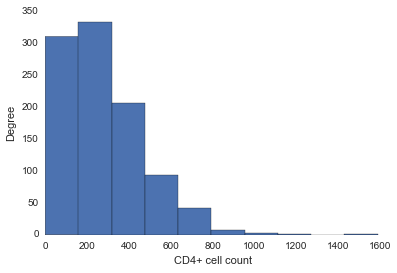

In [13]:
hiv_train['CD4-t0'].plot(kind='hist')
plt.xlabel('CD4+ cell count');

### This is a right skewed distribution, which means it will require some kind of log transformation.

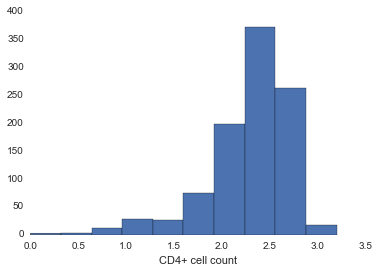

In [14]:
plt.hist(np.log10(hiv_train['CD4-t0'].values + 1))
plt.xlabel('CD4+ cell count');

### It is left skewed distribution meaning that lower values are rare. Most people have reasonable CD4+ cell count.

## Model Building

In [15]:
from __future__ import print_function
import statsmodels.api as sm

In [16]:
X = np.zeros((hiv_train.shape[0], 2))
X[:, 0] = hiv_train['VL-t0'].values
X[:, 1] = hiv_train['CD4-t0'].map(lambda x: np.log10(1 + x)).values

Y = hiv_train.Resp.values

In [17]:
X = sm.add_constant(X)

model = sm.Logit(Y, X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.439998
         Iterations 6


In [18]:
print (results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Sat, 16 May 2015   Pseudo R-squ.:                  0.1349
Time:                        16:34:16   Log-Likelihood:                -440.00
converged:                       True   LL-Null:                       -508.61
                                        LLR p-value:                 1.595e-30
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -8.1725      0.966     -8.457      0.000       -10.066    -6.279
x1             1.4536      0.149      9.761      0.000         1.162     1.746
x2             0.1355      0.194      0.699      0.4

#### CD4+ cell count is not a significant variable since we have such a small dataset, we could try out a simpler model

In [19]:
model1 = sm.Logit(Y, X[:, [0, 1]])
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.440244
         Iterations 6


In [20]:
print (result1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 May 2015   Pseudo R-squ.:                  0.1344
Time:                        16:34:18   Log-Likelihood:                -440.24
converged:                       True   LL-Null:                       -508.61
                                        LLR p-value:                 1.382e-31
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -7.6574      0.620    -12.352      0.000        -8.872    -6.442
x1             1.4067      0.132     10.630      0.000         1.147     1.666


#### Removing CD4+ cell count didn't hurt our model that much.

In [21]:
hiv_test = pd.read_csv('./data/test_data.csv', index_col='PatientID'); hiv_test.shape

(692, 5)

In [22]:
from sklearn.linear_model import LogisticRegression

In [24]:
logreg = LogisticRegression(fit_intercept=True)
logreg.fit(hiv_train['VL-t0'].values.reshape(-1, 1), Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [26]:
print ('Training score %.3f' %(logreg.score(hiv_train['VL-t0'].values.reshape(-1, 1), Y)))

Training score 0.793


In [27]:
# Cross validation
from sklearn.cross_validation import cross_val_score, ShuffleSplit

cv = ShuffleSplit(X.shape[0], n_iter=5, test_size=0.1, random_state=0)
scores = cross_val_score(logreg, hiv_train['VL-t0'].values.reshape(-1, 1), Y, cv=cv)

In [28]:
print ('Min score %.4f, Mean score %.4f and Max score %.4f' %(scores.min(), scores.mean(), scores.max()))

Min score 0.7300, Mean score 0.7840 and Max score 0.8500


In [29]:
# Parameter Tuning
n_C = 10
n_iter = 5
cv = ShuffleSplit(X.shape[0], n_iter=n_iter, test_size=.5, random_state=0)

train_scores = np.zeros((n_C, n_iter))
test_scores = np.zeros((n_C, n_iter))

Cs = np.logspace(0, 3, 10)

for i, C in enumerate(Cs):
    for j, (train, test) in enumerate(cv):
        clf = LogisticRegression(C=C, fit_intercept=True).fit(X[train], Y[train])
        train_scores[i, j] = clf.score(X[train], Y[train])
        test_scores[i, j] = clf.score(X[test], Y[test])


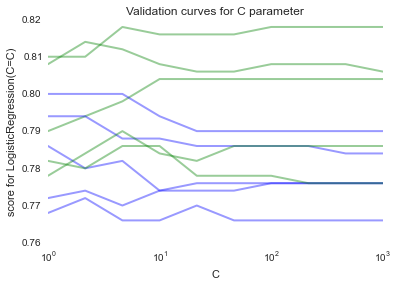

In [30]:
def plot_validation_curves(param_values, train_scores, test_scores):
    for i in range(train_scores.shape[1]):
        plt.semilogx(param_values, train_scores[:, i], alpha=0.4, lw=2, c='b')
        plt.semilogx(param_values, test_scores[:, i], alpha=0.4, lw=2, c='g')
    
plot_validation_curves(Cs, train_scores, test_scores)
plt.ylabel('score for LogisticRegression(C=C)')
plt.xlabel('C')
plt.title('Validation curves for C parameter');

In [31]:
# validation curves
from sklearn.learning_curve import validation_curve

n_Cs = 10
CS = np.logspace(0, 3, 10)

train_scores, test_scores = validation_curve(
    LogisticRegression(fit_intercept=True), X, Y, 'C', Cs, cv=cv)

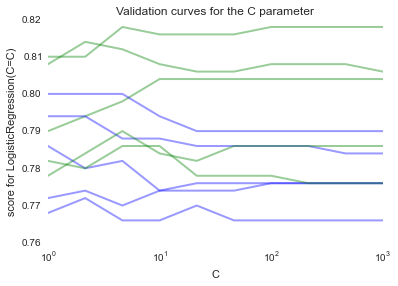

In [32]:
plot_validation_curves(Cs, train_scores, test_scores)
plt.ylabel("score for LogisticRegression(C=C)")
plt.xlabel("C")
plt.title('Validation curves for the C parameter');

In [33]:
# lets train a model on the full dataset
clf = LogisticRegression(C=10, fit_intercept=True)
clf.fit(hiv_train['VL-t0'].values.reshape(-1, 1), Y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [34]:
ypredTrain = clf.predict(hiv_train['VL-t0'].values.reshape(-1, 1))

In [35]:
ypredTrain

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [36]:
ypred = clf.predict(hiv_test['VL-t0'].values.reshape(-1, 1))

In [37]:
ypred

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

### If we do not balance the class equally in the training set as they are in the test set then we get all zero as prediciton which is going to be no good than a random guess